In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import os
import requests
from dotenv import load_dotenv
from sqlalchemy import create_engine

# Load data

In [3]:
# Load data from sql
def load_data(query: str) -> pd.DataFrame:
    # Load environment variables from .env file
    # Gunakan path relatif dari notebook directory
    env_path = os.path.join("..", ".env")
    load_dotenv(dotenv_path=env_path)

    # Retrieve database connection parameters from environment variables
    DB_USER = os.getenv("DB_USER")
    DB_PASSWORD = os.getenv("DB_PASSWORD")
    DB_HOST = os.getenv("DB_HOST")
    DB_PORT = os.getenv("DB_PORT")
    DB_NAME = os.getenv("DB_NAME")

    engine = create_engine(
        f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    )
    with engine.connect() as connection:
        df = pd.read_sql_query(query, connection)
        return df
    
# Example usage
query = "SELECT * FROM raw.pharmacy_sales;"

In [4]:
pd.set_option('display.max_columns', None)
df = load_data(query=query)

# Feature Engineering

In [5]:
# Map month from names to numbers
def month_mapping(df):
    month_map = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4,
        'May': 5, 'June': 6, 'July': 7, 'August': 8,
        'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    df['month'] = df['month'].map(month_map)
    return df
df = month_mapping(df)

In [6]:
df.head()

,distributor,customer_name,city,country,latitude,longitude,channel,sub_channel,product_name,product_class,quantity,price,sales,month,year,sales_rep_name,manager,sales_team
0,Gottlieb-Cruickshank,"Zieme, Doyle and Kunze",Lublin,Poland,51.2333,22.5667,Hospital,Private,Topipizole,Mood Stabilizers,4.0,368.0,1472.0,1,2018,Mary Gerrard,Britanny Bold,Delta
1,Gottlieb-Cruickshank,Feest PLC,Świecie,Poland,53.4167,18.4333,Pharmacy,Retail,Choriotrisin,Antibiotics,7.0,591.0,4137.0,1,2018,Jessica Smith,Britanny Bold,Delta
2,Gottlieb-Cruickshank,Medhurst-Beer Pharmaceutical Limited,Rybnik,Poland,50.0833,18.5000,Pharmacy,Institution,Acantaine,Antibiotics,30.0,66.0,1980.0,1,2018,Steve Pepple,Tracy Banks,Bravo
3,Gottlieb-Cruickshank,Barton Ltd Pharma Plc,Czeladź,Poland,50.3333,19.0833,Hospital,Private,Lioletine Refliruvax,Analgesics,6.0,435.0,2610.0,1,2018,Mary Gerrard,Britanny Bold,Delta
4,Gottlieb-Cruickshank,Keeling LLC Pharmacy,Olsztyn,Poland,53.7800,20.4942,Pharmacy,Retail,Oxymotroban Fexoformin,Analgesics,20.0,458.0,9160.0,1,2018,Anne Wu,Britanny Bold,Delta


# Feature Engineering

In [7]:
# Data preprocessing to add more features like sales_growth_pct, rolling_avg_3m, lag_1_month, sales_volatility, 
def feature_engineering(df):
    df = df.sort_values(by=['product_name', 'year', 'month'])
    
    # Sales Growth Percentage
    df['sales_growth_pct'] = df.groupby('product_name')['sales'].pct_change()

    # 3-Month Rolling Average
    df['rolling_avg_3m'] = (df.groupby('product_name')['sales']
                            .rolling(window=3, min_periods=1)
                            .mean()
                            .reset_index(level=0, drop=True))

    # lag feature 1 month
    df['lag_1_month'] = df.groupby('product_name')['sales'].shift(1)

    # Sales Volatility (Standard Deviation over past 3 months)
    df['sales_volatility'] = df.groupby('product_name')['sales'].transform(lambda x: x.rolling(window=3).std())

    # Sales normalized by Price
    df['sales_clean'] = df['sales'].clip(lower=0) # don't include negative sales values
    df['sales_zscore_price'] = ((df['sales_clean'] - df['sales_clean'].mean()) / df['sales_clean'].std())

    return df

df = feature_engineering(df)

In [8]:
# Handle missing values in the new features
def fill_missing_values(df):
    df['sales_growth_pct'] = df['sales_growth_pct'].fillna(df['sales_growth_pct'].median()).round(2)
    df['rolling_avg_3m'] = df['rolling_avg_3m'].fillna(df['rolling_avg_3m'].median()).round(2)
    df['lag_1_month'] = df['lag_1_month'].fillna(df['lag_1_month'].median()).round(2)
    df['sales_volatility'] = df['sales_volatility'].fillna(df['sales_volatility'].median()).round(2)
    return df

df = fill_missing_values(df)

# Data Encoding

In [9]:
# data encoding
from sklearn.preprocessing import LabelEncoder

df_clean = df.copy() # make a copy to preserve original data

# Encode categorical variables
le = LabelEncoder()
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    df_clean[col] = le.fit_transform(df_clean[col])

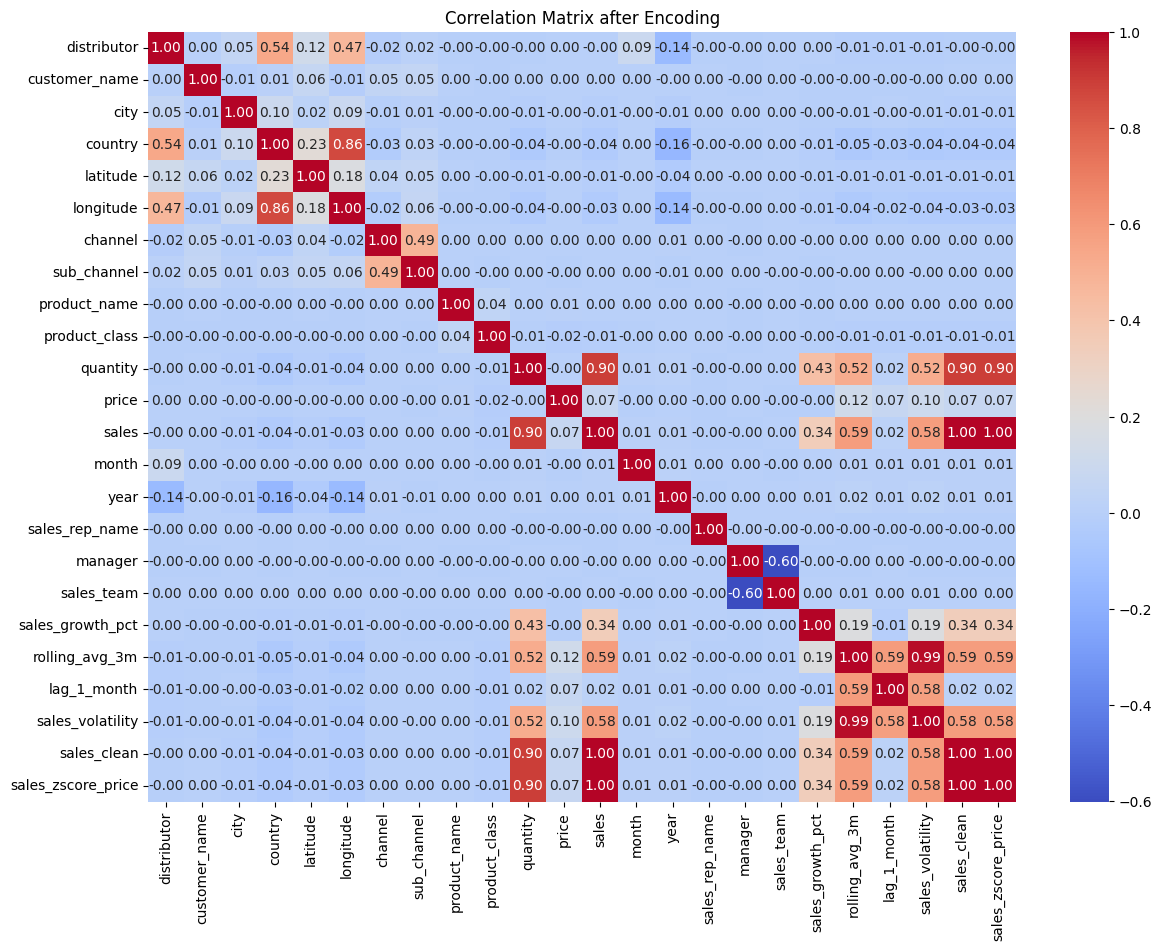

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix after encoding and cleaning
df_clean.corr()

# plotting
plt.figure(figsize=(14, 10))
sns.heatmap(df_clean.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix after Encoding')
plt.show()

# Context Builder (CORE AI ENGINEER)

In [11]:
def build_sales_context(row: pd.Series) -> str:
    return f"""
Customer           : {row.customer_name}
Distributor         : {row.distributor}
Sales Team          : {row.sales_team}
Sales Rep           : {row.sales_rep_name}
Manager             : {row.manager}

Product             : {row.product_name}
Product Class       : {row.product_class}
Channel             : {row.channel} / {row.sub_channel}
Location            : {row.city}, {row.country}
Period              : {int(row.month)}-{int(row.year)}

Sales Metrics:
- Quantity Sold            : {row.quantity}
- Unit Price               : {row.price:.2f}
- Total Sales              : {row.sales:.2f}

Performance Indicators:
- Sales Growth %           : {row.sales_growth_pct:.2f}
- Rolling Avg (3M)         : {row.rolling_avg_3m:.2f}
- Previous Month Sales     : {row.lag_1_month:.2f}
- Sales Volatility         : {row.sales_volatility:.2f}
- Price Z-Score (Anomaly)  : {row.sales_zscore_price:.2f}
"""

# Ollama Client (LLaMA 3)

In [12]:
OLLAMA_URL = "http://localhost:11434/api/generate"
MODEL_NAME = "llama3"

def call_ollama(prompt: str) -> str:
    payload = {
        "model": MODEL_NAME,
        "prompt": prompt,
        "stream": False
    }

    response = requests.post(
        OLLAMA_URL,
        json=payload,
        
    )
    response.raise_for_status()

    return response.json()["response"]

# AI Insight Prompt

In [13]:
def sales_prompt(context: str) -> str:
    return f"""
You are a senior AI sales analyst in a Pharmaceutical distribution company.
Analyze the following sales record:
{context}

Your objectives:
1. Explain current sales performance.
2. Assess sales growth and volatility.
3. Assess whether pricing behavior is abnormal.
4. Identify potential business risk or opportunity.
5. Provide 2-3 concrete, actionable recommendations to improve sales performance.
6. What factors make sales growth and loss?
7. Limit the response to 1000 words. # limit the length of the response.

Rules:
- Be data-driven and specific.
- Do not hallucinate facts outside the provided data.
- Use clear business language.
"""

# Single Row Insight

In [14]:
sample_row = df.sample(1).iloc[0]

context = build_sales_context(sample_row)
prompt = sales_prompt(context)

insight = call_ollama(prompt=prompt)

from IPython.display import HTML, display
display(HTML(f"""
<div style='
    font-size:16px; 
    line-height:1.8; 
    text-align:justify; 
    white-space:pre-wrap; 
    padding:center; 
    border-radius:5px;
    max-width:100%;
'>
{insight}
</div>
"""))

ConnectionError: HTTPConnectionPool(host='localhost', port=11434): Max retries exceeded with url: /api/generate (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x31e0606d0>: Failed to establish a new connection: [Errno 61] Connection refused'))

# Conditional AI Insight (Smart AI Engineer Move)

In [ ]:
def needs_reasoning(row) -> bool:
    return (
        abs(row.sales_zscore_price) > 2 or
        abs(row.sales_growth_pct) > 20 or
        row.sales_volatility > row.rolling_avg_3m
    )

In [15]:
subset = df[df.apply(needs_reasoning, axis=1)].head(10)

subset["insight"] = subset.apply(
    lambda row: call_ollama(
        sales_prompt(
            build_sales_context(row=row)
        )
    ),
    axis=1
)

subset[["customer_name", "product_name", "year", "month", "sales", "sales_growth_pct", "sales_volatility", "sales_zscore_price", "insight"]]

NameError: name 'needs_reasoning' is not defined

In [16]:
subset

NameError: name 'subset' is not defined

# Save AI Insight Output